# Proyecto Integrador

## Score de Riesgo en Originación de Crédito
## Para Kubo Financiero

Participantes:

Dalina Aideé Villa Ocelotl (A01793258)

Julián Valera Juarez (A01793875)

Miguel Guillermo Galindo Orozco (A01793695)


# Ingeniería de Características

### Importar librerías

In [52]:
import sklearn

In [53]:
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import numpy as np

#
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Preprocesado de datos: Pipeline y ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer


from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")

### Lectura de Data

In [54]:
df = pd.read_excel('/content/base_20210101a20240430 (2).xlsx')

In [55]:
df.head(3)

,prospectus_id,Edad,Genero,EstadoCivil,DependientesEconomicos,Estado,ActividadEconomica,NivelEstudios,NumCaracteresSobreMi,consulting_date,...,MontoCredR,NumCredI,MontoCredI,NumCredM,MontoCredM,montocredito_actual,estatus_actual,diasatraso_actual,es_malo_actual,saldo_actual
0,3872,46,Hombre,Casado (sociedad conyugal),1,Ciudad de México,Empleado,Bachillerato,28,2021-09-06 15:19:27,...,14997.0,10.0,98826.0,0.0,0.0,50000,P,0,0,NaN
1,7207,43,Hombre,Soltero,0,Ciudad de México,Empleado,Maestría,113,2021-10-14 13:45:49,...,10469.0,49.0,37484.0,0.0,0.0,48000,P,0,0,NaN
2,8105,51,Mujer,Casado (sociedad conyugal),más de 4,Ciudad de México,Empresario/Socio,Licenciatura,0,2022-05-18 20:06:57,...,527690.0,1.0,113100.0,0.0,0.0,10000,P,0,0,NaN


1. Eliminamos variables que son futuras (o al momento de performance) que no nos sirven para el caso de uso de nuestro modelo de ML.
2. Eliminamos aquellos registros sin flaf de performance (es_malo_actual NULL)

In [56]:
variables_eliminar = ["montocredito_actual", "estatus_actual","diasatraso_actual","saldo_actual"]
variables_ok = [i for i in df.columns if i not in variables_eliminar ]
df = df[variables_ok]

In [57]:
df = df[df['es_malo_actual'].isin([0,1])]

### Separar la base de desarrollo en entrenamiento, test y validación

Se debe separar la base en entrenamiento, test y validación, para realizar todo el Feature Engineering sólo sobre la base de entrenamiento, para no sesgar los resultados, y tener un modelo con fuga de información.

Creamos las variables de mes y año para identificar a nuestra población de validación

In [58]:
df['year'] = pd.to_datetime(df['consulting_date'], format='%m/%d/%Y')
df['month'] = pd.to_datetime(df['consulting_date'], format='%m/%d/%Y')
df['year'] = df['year'].dt.year
df['month'] = df['month'].dt.month
df['cohorte'] = df['year']* 100 + df['month']

Nuestro set de validación, será una validación Out Of Time, tomando todo lo que sea después del 2do semestr del 2023

In [59]:
# Separamos la muestra de validación.

df_oot = df[df['cohorte']>=202307]

df_oot = df_oot.drop(['year','month','cohorte'], axis=1)

df = df[df['cohorte']<202307]

df = df.drop(['year','month','cohorte'], axis=1)

In [60]:
print('Registros en el set de Validación Out Of Time', df_oot.shape[0])
print('Registros en el set de Entrenamiento y Test', df.shape[0])

Registros en el set de Validación Out Of Time 7790
Registros en el set de Entrenamiento y Test 27407


In [61]:
y = df['es_malo_actual']
X = df.drop(['es_malo_actual'], axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state = 1234, shuffle = True)

# Comprobar el número de registros
print('Registros en el set de Entrenamiento', X_train.shape[0])
print('Registros en el set de test', X_test.shape[0])
print(f"El set de Entrenamiento tiene una tasa de mora de {sorted(Counter(y_train).items())[1][1]/X_train.shape[0]} mientras que el set de test tiene una tasa de mora del  {sorted(Counter(y_test).items())[1][1]/X_test.shape[0]}.")

Registros en el set de Entrenamiento 21925
Registros en el set de test 5482
El set de Entrenamiento tiene una tasa de mora de 0.2341619156214367 mientras que el set de test tiene una tasa de mora del  0.23622765414082453.


### Feature Engineering sobre set de entrenamiento

In [63]:
X_train.head(2)

,prospectus_id,Edad,Genero,EstadoCivil,DependientesEconomicos,Estado,ActividadEconomica,NivelEstudios,NumCaracteresSobreMi,consulting_date,...,MontoCredHist,CredMobMayor2,NumCredActivos,MontoCredActivos,NumCredR,MontoCredR,NumCredI,MontoCredI,NumCredM,MontoCredM
10119,3764128,40,Hombre,Unión Libre,1,Ciudad de México,Empleado,Licenciatura,37,2022-01-21 10:26:39,...,118837.0,0.0,8.0,89111.0,6.0,66081.0,4.0,52366.0,0.0,0.0
24494,4913772,29,Mujer,Soltero,0,Baja California,Empleado,Licenciatura,0,2023-03-26 15:33:35,...,25102.0,0.0,2.0,10051.0,4.0,25102.0,0.0,0.0,0.0,0.0


In [64]:
for i in X_train.columns: print (i)

prospectus_id
Edad
Genero
EstadoCivil
DependientesEconomicos
Estado
ActividadEconomica
NivelEstudios
NumCaracteresSobreMi
consulting_date
cci_score
bc_score
NumCredHist
MontoCredHist
CredMobMayor2
NumCredActivos
MontoCredActivos
NumCredR
MontoCredR
NumCredI
MontoCredI
NumCredM
MontoCredM


1. Variables categóricas
2. Estandarizar variables de montos
3. Binarizar Scores

Transformar Variables categóricas a variables dummy por cada valor

In [65]:
categoricas = ["Genero", "EstadoCivil",	"DependientesEconomicos", "Estado",	"ActividadEconomica", "NivelEstudios"]
ct = ColumnTransformer([('encode_cats', OneHotEncoder(), categoricas),],remainder='drop')

Estandarizar variables de montos.

Si bien cada Variable de Monto viene en unidades de pesos Mexicanos, no será lo mismo el monto otorgado en una Tarjeta de Crédito o Préstamo Personal, que para una hipoteca. Por lo cual se decide estandarizar, para tener todos en unidades comparables y con una distribución normal, que favorece el tratamiento de los datos.

In [66]:
variables_montos = ["MontoCredHist", "MontoCredActivos",  "MontoCredR", "MontoCredI" , "MontoCredM"]
st = ColumnTransformer([('stdSc_', StandardScaler(), variables_montos),],remainder='drop')

In [67]:
pd.DataFrame(st.fit_transform(df), columns = st.get_feature_names_out())

,stdSc___MontoCredHist,stdSc___MontoCredActivos,stdSc___MontoCredR,stdSc___MontoCredI,stdSc___MontoCredM
0,-0.065404,-0.350462,-0.364603,-0.037116,-0.233013
1,-0.075316,-0.444406,-0.383897,-0.045861,-0.233013
2,0.008718,0.012902,1.819922,-0.035081,-0.233013
3,0.032843,0.016756,0.873806,-0.015037,0.286439
4,-0.057436,-0.266663,-0.026221,-0.039685,-0.233013
...,...,...,...,...,...
27402,-0.041355,-0.322996,-0.409884,-0.010658,-0.233013
27403,0.009014,0.259219,0.006098,0.026013,-0.233013
27404,-0.071968,-0.468232,-0.379930,-0.042480,-0.233013
27405,-0.036384,-0.231318,-0.041190,-0.018017,-0.233013


Dejandolos en un sólo paso

In [68]:
categorical_transformer = OneHotEncoder(sparse_output=False)
montos_transformer = StandardScaler()

**Realizar Bin sobre Scores.**

Cocemos que dentro de la base vienen 2 scores que evaluan el riesgo y la capacidad de endeudamiento de un cliente:

cci_score = Índice de capacidad crediticia de un cliente.
bc_score = Score de Riesgo de BUró de Crédito.

Ambos scores serán utilizados como insumos para nuestro modelo, pero no entrarán tal cual su score actual, sino como una transformación, tomando la variable en bins de acuerdo al decil que pertenecen.

Como ejemplo, el bc_score, en deciles nos dirá en qué segmento de riesgo pertenece comparado con los demás dentro de la cartera de entreanamiento.

Para realizar lo anterior propuesto, primero observamos el **comportamiento del bc_score con la bandera de malo**

In [69]:
bb = df[['prospectus_id','bc_score','es_malo_actual']]
bb['bin'] = pd.qcut(bb['bc_score'],10 ,duplicates='drop')
Odds=bb.groupby('bin').agg({'es_malo_actual':['size','sum','mean']}).reset_index()
Odds.columns=['Bin','Personas','Malos','Bad_rate']
Odds['Buenos'] = Odds['Personas'] - Odds['Malos']

Odds = Odds.sort_index(ascending=True)
Odds['Good_rate']=Odds['Buenos'].div(Odds['Buenos'].sum())
Odds['Tasa_malos_acum'] = Odds['Malos'].cumsum().div(Odds['Malos'].sum())
Odds['Tasa_buenos_acum'] = Odds['Buenos'].cumsum().div(Odds['Buenos'].sum())
Odds['M_1']=Odds['Malos'].values[::-1].cumsum()
Odds['M_2']=Odds['M_1'].values[::-1]
Odds['P_1']=Odds['Personas'].values[::-1].cumsum()
Odds['P_2']=Odds['P_1'].values[::-1]
Odds['Mora_acumulada']=Odds['M_2'].div(Odds['P_2'])
Odds['KS'] = np.abs(Odds['Tasa_malos_acum'] - Odds['Tasa_buenos_acum'])
Odds['Var_ROC']=Odds['Good_rate']*Odds['Tasa_malos_acum']

Ks_CI=round(Odds['KS'].max(),4)*100
ROC=Odds['Var_ROC'].sum()*100
tabla_ODDS=Odds[['Bin','Personas','Buenos','Malos','Bad_rate','Mora_acumulada','KS']]

resultados={'Casos':bb.shape[0], 'Malos':bb['es_malo_actual'].sum(), 'Tasa de Mora':bb['es_malo_actual'].sum()/bb['es_malo_actual'].count(), 'KS':Ks_CI, 'ROC':ROC }
resultados=pd.DataFrame(resultados,columns=['Casos','Malos','Tasa de Mora','KS','ROC'],index=['Resumen_resultados'])

In [70]:
tabla_ODDS

,Bin,Personas,Buenos,Malos,Bad_rate,Mora_acumulada,KS
0,"(-9.001, 647.0]",3119,2184,935,0.299776,0.234575,0.041326
1,"(647.0, 652.0]",2829,2050,779,0.275362,0.226202,0.064774
2,"(652.0, 656.0]",2494,1848,646,0.259022,0.219721,0.077164
3,"(656.0, 660.0]",2710,2036,674,0.248708,0.214553,0.084947
4,"(660.0, 664.0]",2567,1942,625,0.243475,0.208859,0.089590
5,"(664.0, 669.0]",2981,2312,669,0.224421,0.202367,0.083439
6,"(669.0, 675.0]",2954,2322,632,0.213947,0.196227,0.071056
7,"(675.0, 681.0]",2340,1887,453,0.193590,0.189475,0.051567
8,"(681.0, 692.0]",2821,2298,523,0.185395,0.187696,0.023373
9,"(692.0, 750.0]",2592,2099,493,0.190201,0.190201,0.000000


Para realizar lo anterior propuesto, primero observamos el **comportamiento del cci_score con la bandera de malo**

In [71]:
bb = df[['prospectus_id','cci_score','es_malo_actual']]
bb['bin'] = pd.qcut(bb['cci_score'],10 ,duplicates='drop')
Odds=bb.groupby('bin').agg({'es_malo_actual':['size','sum','mean']}).reset_index()
Odds.columns=['Bin','Personas','Malos','Bad_rate']
Odds['Buenos'] = Odds['Personas'] - Odds['Malos']

Odds = Odds.sort_index(ascending=True)
Odds['Good_rate']=Odds['Buenos'].div(Odds['Buenos'].sum())
Odds['Tasa_malos_acum'] = Odds['Malos'].cumsum().div(Odds['Malos'].sum())
Odds['Tasa_buenos_acum'] = Odds['Buenos'].cumsum().div(Odds['Buenos'].sum())
Odds['M_1']=Odds['Malos'].values[::-1].cumsum()
Odds['M_2']=Odds['M_1'].values[::-1]
Odds['P_1']=Odds['Personas'].values[::-1].cumsum()
Odds['P_2']=Odds['P_1'].values[::-1]
Odds['Mora_acumulada']=Odds['M_2'].div(Odds['P_2'])
Odds['KS'] = np.abs(Odds['Tasa_malos_acum'] - Odds['Tasa_buenos_acum'])
Odds['Var_ROC']=Odds['Good_rate']*Odds['Tasa_malos_acum']

Ks_CI=round(Odds['KS'].max(),4)*100
ROC=Odds['Var_ROC'].sum()*100
tabla_ODDS=Odds[['Bin','Personas','Buenos','Malos','Bad_rate','Mora_acumulada','KS']]

resultados={'Casos':bb.shape[0], 'Malos':bb['es_malo_actual'].sum(), 'Tasa de Mora':bb['es_malo_actual'].sum()/bb['es_malo_actual'].count(), 'KS':Ks_CI, 'ROC':ROC }
resultados=pd.DataFrame(resultados,columns=['Casos','Malos','Tasa de Mora','KS','ROC'],index=['Resumen_resultados'])

In [72]:
tabla_ODDS

,Bin,Personas,Buenos,Malos,Bad_rate,Mora_acumulada,KS
0,"(-3.001, 5.0]",5726,4166,1560,0.272441,0.234575,0.044061
1,"(5.0, 6.0]",5486,4123,1363,0.248451,0.224575,0.059530
2,"(6.0, 7.0]",9015,6877,2138,0.237160,0.216487,0.064266
3,"(7.0, 8.0]",5154,4182,972,0.188591,0.190529,0.016105
4,"(8.0, 9.0]",2026,1630,396,0.195459,0.195459,0.000000


Con los resultados anteriores definimos las siguientes funciones que aplicaremos para transformar las variables

In [73]:
def decil_bc(df):
    df['decil_bc'] = np.select([df['bc_score']<647,
                                df['bc_score']<652,
                                 df['bc_score']<656,
                                  df['bc_score']<660,
                                   df['bc_score']<664,
                                    df['bc_score']<669,
                                     df['bc_score']<675,
                                      df['bc_score']<681,
                                       df['bc_score']<692,
                                        df['bc_score']<1200],[1,2,3,4,5,6,7,8,9,10],0)
    return df


def quintil_cci(df):
    df['quintil_cci'] = np.select([df['cci_score']<5,
                                df['cci_score']<6,
                                 df['cci_score']<7,
                                  df['cci_score']<8,
                                   df['cci_score']<9
                                   ],[1,2,3,4,5],0)
    return df

def keep(df):
    df['Edad'] = df['Edad']
    df['NumCaracteresSobreMi'] = df['NumCaracteresSobreMi']
    df['NumCredHist'] = df['NumCredHist']
    df['CredMobMayor2'] = df['CredMobMayor2']
    df['NumCredActivos'] = df['NumCredActivos']
    df['NumCredR'] = df['NumCredR']
    df['NumCredI'] = df['NumCredI']
    df['NumCredM'] = df['NumCredM']
    return df


Realizamos el feature Engineering con las funciones previamente definidas

In [74]:
feature_engineering = ColumnTransformer([
    ('score_bc', FunctionTransformer(decil_bc, validate=False),['bc_score']),
    ('score_cci', FunctionTransformer(quintil_cci, validate=False),['cci_score']),
    ('', FunctionTransformer(keep, validate=False),['Edad',	'NumCaracteresSobreMi','NumCredHist',	'CredMobMayor2',	'NumCredActivos',	'NumCredR', 'NumCredI'	,'NumCredM']),
    ])
feature_engineering.set_output(transform="pandas")

ColumnTransformer(transformers=[('score_bc',
                                 FunctionTransformer(func=<function decil_bc at 0x7fd43d968040>),
                                 ['bc_score']),
                                ('score_cci',
                                 FunctionTransformer(func=<function quintil_cci at 0x7fd43d9680d0>),
                                 ['cci_score']),
                                ('',
                                 FunctionTransformer(func=<function keep at 0x7fd43d968160>),
                                 ['Edad', 'NumCaracteresSobreMi', 'NumCredHist',
                                  'CredMobMayor2', 'NumCredActivos', 'NumCredR',
                                  'NumCredI', 'NumCredM'])])

In [75]:
numeric_columns = list(X_train.select_dtypes(exclude=['object']).columns.values.tolist())

Aplicamos transormadores para cada segmento del Feature Engineering:

1. Variables categóricas.
2. Variables de Montos.
3. Bins sobre variables de scores.

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_', categorical_transformer, categoricas),
        ('montos_', montos_transformer, variables_montos),
        ('bin_', feature_engineering, numeric_columns)
    ],remainder='passthrough')

preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_', OneHotEncoder(sparse_output=False),
                                 ['Genero', 'EstadoCivil',
                                  'DependientesEconomicos', 'Estado',
                                  'ActividadEconomica', 'NivelEstudios']),
                                ('montos_', StandardScaler(),
                                 ['MontoCredHist', 'MontoCredActivos',
                                  'MontoCredR', 'MontoCredI', 'MontoCredM']),
                                ('bin_',
                                 ColumnTransformer(transformers=[('score_b...
                                                                   'NumCaracteresSobreMi',
                                                                   'NumCredHist',
                                                                   'CredMobMayor2',
                                                                   'NumCredActivos',
                                                                   'NumCredR',
                                                                   'NumCredI',
                                                                   'NumCredM'])]),
                                 ['prospectus_id', 'Edad',
                                  'NumCaracteresSobreMi', 'consulting_date',
                                  'cci_score', 'bc_score', 'NumCredHist',
                                  'MontoCredHist', 'CredMobMayor2',
                                  'NumCredActivos', 'MontoCredActivos',
                                  'NumCredR', 'MontoCredR', 'NumCredI',
                                  'MontoCredI', 'NumCredM', 'MontoCredM'])])

In [77]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

In [78]:
class keepTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X

    def fit(self, X, y=None):
        return self

Pipeline para aplicarlo a cualquier dataframe

In [79]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ("columnDropper", columnDropperTransformer(['bin___score_bc__bc_score','bin___score_cci__cci_score']))
                           ])
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Genero', 'EstadoCivil',
                                                   'DependientesEconomicos',
                                                   'Estado',
                                                   'ActividadEconomica',
                                                   'NivelEstudios']),
                                                 ('montos_', StandardScaler(),
                                                  ['MontoCredHist',
                                                   'MontoCredActivos',
                                                   'MontoCredR', 'MontoCredI',
                                                   'MontoCredM']),
                                                 ('bin_',
                                                  ColumnTra...
                                                                                    'NumCredI',
                                                                                    'NumCredM'])]),
                                                  ['prospectus_id', 'Edad',
                                                   'NumCaracteresSobreMi',
                                                   'consulting_date',
                                                   'cci_score', 'bc_score',
                                                   'NumCredHist',
                                                   'MontoCredHist',
                                                   'CredMobMayor2',
                                                   'NumCredActivos',
                                                   'MontoCredActivos',
                                                   'NumCredR', 'MontoCredR',
                                                   'NumCredI', 'MontoCredI',
                                                   'NumCredM',
                                                   'MontoCredM'])])),
                ('columnDropper',
                 <__main__.columnDropperTransformer object at 0x7fd440b85f30>)])

In [80]:
X_train_tr= pipeline.transform(X_train)

X_train_tr = X_train_tr.rename(columns={'bin_____Edad': 'Edad',
                           'bin_____NumCaracteresSobreMi': 'NumCaracteresSobreMi',
                        'bin_____NumCredHist': 'NumCredHist',
                        'bin_____CredMobMayor2': 'CredMobMayor2',
                        'bin_____NumCredR': 'NumCredR',
                        'bin_____NumCredActivos': 'NumCredActivos',
                        'bin_____NumCredI': 'NumCredI',
                        'bin_____NumCredM': 'NumCredM'})



In [81]:
X_train_tr

,cat___Genero_Hombre,cat___Genero_Mujer,cat___EstadoCivil_Casado (bienes separados),cat___EstadoCivil_Casado (sociedad conyugal),cat___EstadoCivil_Divorciado,cat___EstadoCivil_Soltero,cat___EstadoCivil_Unión Libre,cat___EstadoCivil_Viudo,cat___DependientesEconomicos_0,cat___DependientesEconomicos_1,...,bin___score_bc__decil_bc,bin___score_cci__quintil_cci,Edad,NumCaracteresSobreMi,NumCredHist,CredMobMayor2,NumCredActivos,NumCredR,NumCredI,NumCredM
10119,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,10,5,40,37,11.0,0.0,8.0,6.0,4.0,0.0
24494,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,5,3,29,0,4.0,0.0,2.0,4.0,0.0,0.0
3941,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,4,27,0,2.0,0.0,2.0,2.0,0.0,0.0
4246,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,2,37,23,21.0,0.0,8.0,8.0,10.0,0.0
11686,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,9,5,29,45,4.0,0.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17266,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4,1,30,14,14.0,0.0,3.0,2.0,12.0,0.0
24229,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3,1,31,0,21.0,1.0,12.0,13.0,4.0,2.0
23907,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,10,4,33,0,6.0,0.0,3.0,2.0,2.0,1.0
1423,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,9,4,30,112,12.0,0.0,7.0,9.0,3.0,0.0


In [82]:
for i in X_train_tr.columns: print(i)

cat___Genero_Hombre
cat___Genero_Mujer
cat___EstadoCivil_Casado (bienes separados)
cat___EstadoCivil_Casado (sociedad conyugal)
cat___EstadoCivil_Divorciado
cat___EstadoCivil_Soltero
cat___EstadoCivil_Unión Libre
cat___EstadoCivil_Viudo
cat___DependientesEconomicos_0
cat___DependientesEconomicos_1
cat___DependientesEconomicos_2
cat___DependientesEconomicos_3
cat___DependientesEconomicos_4
cat___DependientesEconomicos_más de 4
cat___Estado_Aguascalientes
cat___Estado_Baja California
cat___Estado_Baja California Sur
cat___Estado_Campeche
cat___Estado_Chiapas
cat___Estado_Chihuahua
cat___Estado_Ciudad de México
cat___Estado_Coahuila de Zaragoza
cat___Estado_Colima
cat___Estado_Durango
cat___Estado_Estado de México
cat___Estado_Extranjero
cat___Estado_Guanajuato
cat___Estado_Guerrero
cat___Estado_Hidalgo
cat___Estado_Jalisco
cat___Estado_Michoacán de Ocampo
cat___Estado_Morelos
cat___Estado_Nayarit
cat___Estado_Nuevo León
cat___Estado_Oaxaca
cat___Estado_Puebla
cat___Estado_Querétaro de Ar

In [83]:
X_test_tr= pipeline.transform(X_test)

X_test_tr = X_test_tr.rename(columns={'bin_____Edad': 'Edad',
                           'bin_____NumCaracteresSobreMi': 'NumCaracteresSobreMi',
                        'bin_____NumCredHist': 'NumCredHist',
                        'bin_____CredMobMayor2': 'CredMobMayor2',
                        'bin_____NumCredR': 'NumCredR',
                        'bin_____NumCredActivos': 'NumCredActivos',
                        'bin_____NumCredI': 'NumCredI',
                        'bin_____NumCredM': 'NumCredM'})



In [88]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Imputar los valores NaN en X_train_normalized
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_normalized)

# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_train_imputed)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Mostrar la varianza explicada por cada componente
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)

# Seleccionar las variables más importantes
components = pca.components_
most_important_variables = [X_train_numeric.columns[i] for i in components.argmax(axis=1)]

print("Variables más importantes:", most_important_variables)







Varianza explicada por cada componente: [0.21054629 0.14739701]
Variables más importantes: ['MontoCredActivos', 'MontoCredM']


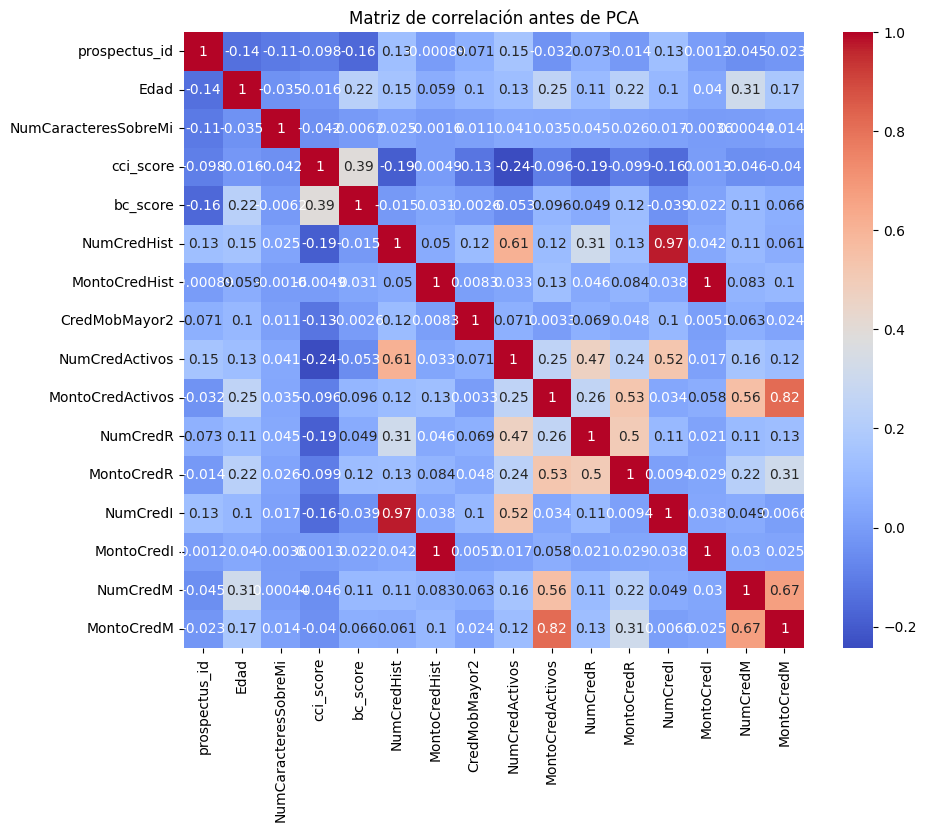

In [90]:
# Seleccionar solo las columnas numéricas
X_train_numeric = X_train.select_dtypes(include=[np.number])

# Mostrar matriz de correlación antes de PCA
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación antes de PCA')
plt.show()

Conclusiones

Para la fase de "Preparación de los datos" en el contexto de la metodología CRISP-ML, es fundamental seguir una serie de pasos para garantizar la calidad y la adecuación de los datos antes de utilizarlos en modelos de aprendizaje automático. Estos pasos incluyen la generación de nuevas características, la discretización o binning, la codificación, el escalamiento, la transformación, así como métodos de filtrado y técnicas de extracción de características. Es importante justificar todas las decisiones y técnicas utilizadas en este proceso.

Generación de nuevas características: Esta etapa implica crear nuevas variables que pueden ser útiles para el modelo, puede generar una nueva característica que combine el precio de un producto con la cantidad vendida para obtener el ingreso total.

Discretización o binning: Consiste en dividir una variable numérica en intervalos discretos.

Codificación: Se refiere a la transformación de variables categóricas en variables numéricas. Puede ser ordinal, donde se asigna un valor numérico a cada categoría en función de su orden, o one-hot encoding, donde se crea una nueva variable binaria para cada categoría.

Escalamiento: Es el proceso de estandarizar o normalizar las variables numéricas para que tengan una escala común. Esto evita que una variable domine sobre otra en el modelo. Métodos comunes incluyen la normalización, la estandarización y el escalado min-max.

Transformación: Se utilizan transformaciones matemáticas para modificar la distribución de una variable. Por ejemplo, una transformación logarítmica puede hacer que una distribución sesgada hacia la derecha se parezca más a una distribución normal.

Para la selección de características, se pueden aplicar métodos de filtrado para identificar las características más relevantes para el modelo y a reducir la dimensionalidad del conjunto de datos.

